# Figures two-cell case

Code to reproduce figures 3(b) - 3(d), S3 and S4.

# Import packages 

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
from scipy.special import xlogy
import multiprocess as mp
import matplotlib

In [4]:
# Set the number of cores for multiprocessing = to the number of available cores
ncores = os.cpu_count()

# Model 

Equations describing the temporal evolution of $R_b$, $Q_b$ and $E^*$ (Eq.1-3 of the main text): 

$\dot{R}_b = k_{d\scriptscriptstyle+}c (R-R_b) - k_{d\scriptscriptstyle-} R_b+ \xi_{R} ;$ 

    
$\dot{Q}_b= k_{e\scriptscriptstyle+} e (Q-Q_b) - k_{e\scriptscriptstyle-} Q_b+ \xi_{Q} ; $ 


$ \dot{E}^* = V_s \frac{R_b^2}{R_b^2 + K_s^2}(E_T- E^*) - \left ( V_{rg}\frac{Q_b}{Q_b + K_{rg}} + k \right ) E^* + \xi_{E}$ 


Standard values of the parameters

In [8]:
# Normalized concentration of molecules c_v = [FGF]/[FGF]_0, e_v = [eph]/[eph]_0
c_v =  5  
e_v =  5 

# Total number of molecules in each cell
Rt_v =  2000 # Total number of FGF receptors
Qt_v =  2000 # Total number of ephrin receptors
Erkt_v= 4000 # Total number of ERK molecules

# Values of the reaction rates  
Kd =  60 # Normalised binding constant of FGF
kd_plus_v = 0.1  
kd_minus_v = Kd*kd_plus_v
 
Ke =  40 # Normalised binding constant of ephrin
ke_plus_v = 0.1 
ke_minus_v = Ke*ke_plus_v

k_v =  0.2 # ERK* de-activation constant
Vs_v=  1*k_v # Maximal rate of ERK activation (by Rb)
Vrg_v = 0.4*k_v # Maximal rate of ERK* deactivation (by Qb)

Ks_v =  200  # Half saturation constant for Rb
Krg_v =  200 # Half saturation constant for Qb

# Cell surface
Scell_v = 6000 # Total cell surface (um^2)
S1max = Scell_v/2 # Maximum surface exposed to FGF
S1_v = 0.5*Scell_v # Surface exposed to FGF (um^2)

# The surface exposed to FGF (S1) is related to the surface exposed to ephrin (S2) through Eq.5:
# S2 = A*S1+B*Scell  
A = -1.1265
B = 0.9092

Function to compute the number of active ERK molecules ($E^*$) (Eq. 1-3)

In [10]:
# Function to compute ERK as a function of the input 
def ERK(c, args, varS1=False):  
    
    kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)
        
    return np.float32(Erk_ss) 

Function to compute the noise in the number of active ERK molecules ($\sigma_e$) (Eq. 22 - 28)

In [12]:
# Function to compute the noise as a function of the input 
def sigma(c, args, varS1=False):
    
    kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)

    Tau_c = (kd_plus*c+kd_minus)**(-1)
    Tau_e = (ke_plus*e+ke_minus)**(-1)
    Tau_E = (k + Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg) )**(-1)

    Gamma_R = 2*Vs*Rb_ss*Ks**2/(Rb_ss**2+Ks**2)**2*(Erkt-Erk_ss)
    Gamma_Q = Vrg*Krg/(Qb_ss+Krg)**2*Erk_ss

    n_ss = c*kd_plus/(kd_minus + c*kd_plus)
    m_ss = e*ke_plus/(ke_minus + e*ke_plus)

    A_R = 2/Tau_c*Rt*S1/Scell*n_ss*(1-n_ss)
    A_Q = 2/Tau_e*Qt*S2/Scell*m_ss*(1-m_ss)
    A_E = 2*Vs*Rb_ss**2/(Rb_ss**2+Ks**2)*(Erkt-Erk_ss)

    sigma_R = Gamma_R**2*A_R/2*(Tau_c-Tau_E)/(Tau_E**(-2)-Tau_c**(-2))
    sigma_Q = Gamma_Q**2*A_Q/2*(Tau_e-Tau_E)/(Tau_E**(-2)-Tau_e**(-2))
    sigma_E = A_E/2*Tau_E

    sigma2 = sigma_R + sigma_Q + sigma_E
        
    return np.float32(np.sqrt(sigma2))

# Information transmission

Input probability distribution $P(c)$: lognormal distribution centered around $\mu_c$, with variance $\sigma_F^2$.

$P(c) = \frac{1}{c \sqrt{2\pi \sigma_F^2}} \exp{\left (-\frac{(\ln{(c)}-\mu_c)^2}{\sigma_F^2} \right )}$   (Eq. 7 of the main text)

In [15]:
# Lognormal distribution
def Pf_Lognorm(var, mu_c, sigma_F): 
    mu = np.log(mu_c**2/np.sqrt(mu_c**2+sigma_F**2))
    sig = np.sqrt(np.log(1+sigma_F**2/mu_c**2))
    distr = 1/(2*np.pi*sig**2*var**2)**(1/2)*np.exp(-1/2*((np.log(var)-mu)/sig)**2) 
    return distr

Function to compute the conditional probability distribution $P(E^*|c) = \mathcal{G}(E^*, \bar{E}^*, \sigma_e^2)$ (Eq. 9)

In [17]:
def P_ERKF(var, ERK_temp, args):
    
    # Gaussian centered around ERK_v, with std = sigma_v 
    ERK_v = ERK(var, args=args)
    sigma_v = sigma(var, args=args)

    distr = 1/(2*np.pi*sigma_v**2)**(1/2)*np.exp(-1/2*((ERK_temp - ERK_v)/sigma_v)**2)   
    
    # Return the normalized distribution    
    return distr/np.trapz(distr,ERK_temp)

Function to compute the output probability distribution:

$P(\{E_A^*, E_B^*\}) = \int P(\{E_A^*, E_B^*\}|c) P(c) dc$   (Eq. 33 of the main text with N=2)

In [19]:
def PERK_2c(ERK_cellA, ERK_cellB, c_temp, Pc, argsA, argsB):
    
    distr = np.zeros((len(ERK_cellB), len(ERK_cellA)))
    
    for i in range(1, len(c_temp)): 
        Perkf_cellA_1 = np.float32(P_ERKF(c_temp[i], ERK_cellA, args=argsA))
        Perkf_cellB_1 = np.float32(P_ERKF(c_temp[i], ERK_cellB, args=argsB))

        Perkf_cellA_0 = np.float32(P_ERKF(c_temp[i-1], ERK_cellA, args=argsA))
        Perkf_cellB_0 = np.float32(P_ERKF(c_temp[i-1], ERK_cellB, args=argsB))
         
        integrand_1 = Perkf_cellA_1*np.vstack(Perkf_cellB_1)*np.float32(Pc[i])
        integrand_0 = Perkf_cellA_0*np.vstack(Perkf_cellB_0)*np.float32(Pc[i-1])
            
        del Perkf_cellA_1, Perkf_cellB_1, Perkf_cellA_0, Perkf_cellB_0
        
        delta_c = np.float32(c_temp[i]-c_temp[i-1])
        integral_step = (integrand_1+integrand_0)*delta_c/2
        
        del  integrand_1, integrand_0
        
        distr= distr + integral_step
    
    # Return the output distribution
    return distr

Function to compute the entropy of $P(\{E_A^*, E_B^*\})$:

$ S[P(\{E_A^*, E_B^*\})] = \int P(\{E_A^*, E_B^*\}) \log_2(P(\{E_A^*, E_B^*\})) dE_A^* dE_B^*$ 

In [21]:
def SPERK_2c(ERK_cellA, ERK_cellB, c_temp, Pc, argsA, argsB):
    
    distr = PERK_2c(ERK_cellA, ERK_cellB, c_temp, Pc, argsA, argsB)
    
    integral = - np.trapz(np.trapz(xlogy(distr, distr)/np.log(2), ERK_cellA, axis=1), ERK_cellB)
    
    # Return the integral of the output distribution
    return integral

Function to compute information:

$I(c;\{E_A^*, E_B^*\}) =- \int P(\{E_A^*, E_B^*\})\log_2(P(\{E_A^*, E_B^*\})) dE^* + \int dc P(c) \int P(\{E_A^*, E_B^*\}|c)\log_2(P(\{E_A^*, E_B^*\}|c)) dE_A^* dE_B^* \quad $ (Eq. 30 with N=2)


$ \hspace{2.9 cm} = S[P(\{E_A^*, E_B^*\})] + \int dc P(c) \Big [ \int P(E_A^*|c)\log_2(P(E_A^*|c)) dE_A^*  + \int P(E_B^*|c)\log_2(P(E_B^*|c)) dE_B^* \Big ]$ 

$ \hspace{2.9 cm} = S[P(\{E_A^*, E_B^*\})] - \int dc P(c) \Big [ \log_2\left (\sqrt{2\pi e}\sigma_A(c) \right) +  \log_2 \left (\sqrt{2\pi e}\sigma_B(c) \right) \Big ]$ 

In [23]:
def I_2cells(c_temp, Pin, SPout, argsA, argsB):

    # Compute int P({EA, EB}|c)log2(P({EA, EB}|c)) dEA 
    sigma_A = sigma(c_temp, args=argsA)
    sigma_B = sigma(c_temp, args=argsB)
    I2= - np.log2(2*np.pi*np.exp(1)*sigma_A*sigma_B) 
    
    # Compute int P(c)*I2 dc
    I3 = np.trapz(I2*np.float32(Pin), c_temp)
    
    # Return information
    return SPout + I3

Re-write the functions for multiprocessing:

In [25]:
# Function to compute S[P({EA, EB})]
def SPERK_mp(arg_Spout):
    
    ERK_cellA, ERK_cellB, c_temp, Pc, argsA, argsB = arg_Spout
    SPout = SPERK_2c(ERK_cellA, ERK_cellB, c_temp, Pc, argsA, argsB)
                        
    return SPout

# Function to compute I(c; {EA, EB})
def I_2cells_mp(arg_I):
    
    c_temp, Pin, SPout, argsA, argsB = arg_I
    Info = I_2cells(c_temp, Pin, SPout, argsA, argsB)
    
    return Info

## Fig. 3(b) and S4

The following code reproduces Fig. 3(b).

To reproduce Fig. S4 impose ScellA_v = 3000, ScellB_v = 6000

Compute the heatmap for all the possible values of $S_1^A$ and $S_1^B$. The code might take a few minutes to run. 

In [29]:
# Total cell surfaces
ScellA_v= 6000 
ScellB_v= 6000 

# Min and max values for S1
SmaxA= 0.5*ScellA_v
SmaxB= 0.5*ScellB_v

SminA= SmaxA/10
SminB= SmaxA/10

# Create vectors with all possible values of S1A and S1B (for the heatmap)
n = 50  # To exactly reproduce Fig. 3(b) use n= 100
S1A_t0 = np.linspace(SminB,SmaxB, n)
S1B_t0 = np.linspace(SminB,SmaxB, n)

S1A_t, S1B_t = np.meshgrid(S1A_t0, S1B_t0)

S1A_tt = S1A_t.ravel() 
S1B_tt = S1B_t.ravel() 

del S1A_t, S1B_t

In [30]:
S1_prova= 100

# Compute the input distribution
mu_c = 40
sigma_F= 1

cmin = np.max((mu_c -5*sigma_F, 0.1))
cmax = mu_c +5*sigma_F
c_temp = np.linspace(cmin, cmax, 50)
P_in =  Pf_Lognorm(c_temp, sigma_F=sigma_F, mu_c=mu_c)

# Define the parameter values 
arA = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_prova, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, ScellA_v]
arB = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_prova, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, ScellB_v]

# Compute the entropy of the output distribution for all the possible values of S1A and S1B
arg_Spout = [] 

for i in range(len(S1A_tt)): 
    
    # Update the list of parameters with the correct values of S1A and S1B
    argsA = arA[0:4]+[S1A_tt[i]]+arA[5:]
    argsB = arB[0:4]+[S1B_tt[i]]+arB[5:]
    
    ERKvAmin = ERK(cmin, args=argsA)
    ERKvBmin = ERK(cmin, args=argsB)
    
    ERKvAmax = ERK(cmax, args=argsA)
    ERKvBmax = ERK(cmax, args=argsB)
    
    ERKminA = np.max((ERKvAmin-ERKvAmin/4, 1e-4))
    ERKminB = np.max((ERKvBmin-ERKvBmin/4, 1e-4))

    ERK_S1A = np.linspace(ERKminA, ERKvAmax+ERKvAmax/4, 100)
    ERK_S1B = np.linspace(ERKminB, ERKvBmax+ERKvBmax/4, 100)
    
    # Create list of arguments needed to compute S[P({EA, EB})]
    arg_Spout.append((ERK_S1A, ERK_S1B, c_temp, P_in, argsA, argsB))

if __name__ == '__main__': 
    p = mp.Pool(ncores)

    # Compute the entropy of the output distribution
    SPout_2cells = p.map(SPERK_mp, arg_Spout)
    

# Compute information for the different values of S1A and S1B
arg_I = []
for i in range(len(S1A_tt)):
    argsA = arA[0:4]+[S1A_tt[i]]+arA[5:]
    argsB = arB[0:4]+[S1B_tt[i]]+arB[5:]
    
    arg_I.append((c_temp, P_in, SPout_2cells[i], argsA, argsB))
    
if __name__ == '__main__': 
    p = mp.Pool(ncores)

    # Compute the output probability distribution
    Info_S1AS1B = p.map(I_2cells_mp, arg_I)
    
I_S1AS1B_mat = np.reshape(Info_S1AS1B, (n,n))


In [31]:
# If ScellA = 3000 and ScellB= 6000 

if ScellA_v != ScellB_v:
    I_S1AS1B_mat[:, n//2+1:]= 'NaN'

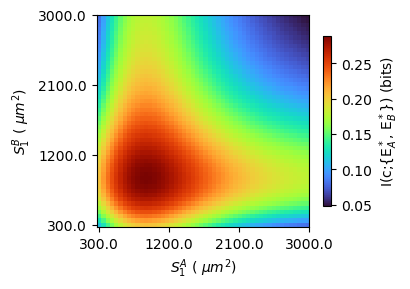

In [32]:
# Figure 
x_tlabels= np.linspace(np.min(S1A_tt),np.max(S1A_tt),4) # S1A temp
y_tlabels= np.linspace(np.min(S1B_tt),np.max(S1B_tt),4) # S1B temp
xLab = [str(np.round(x_tlabels[i],2)) for i in range(len(x_tlabels))]
yLab = [str(np.round(y_tlabels[i],2)) for i in range(len(x_tlabels))]

n = len(S1A_t0)
plt.figure(figsize=(4,3))
plt.imshow( I_S1AS1B_mat, cmap='turbo', origin='lower')
plt.xticks(np.linspace(0,n-0.5,4), labels = xLab )
plt.yticks(np.linspace(0,n-0.5,4), labels = yLab )
plt.colorbar(label='I(c;{E$_A^*$, E$_B^*$}) (bits)', shrink=0.8)

plt.xlabel('$S_{1}^A$ ( $\\mu m^2$)', fontsize=10)
plt.ylabel('$S_{1}^B$ ( $\\mu m^2$)', fontsize=10)

plt.tight_layout()
plt.show()

Compute the information along the straight lines defined by $S_1^A + S_1^B = S_1^{tot}$

In [34]:
# Vector with the different values of S1tot 
S1totmax = (SmaxA + SmaxB)
S1totmin = SminA + SminB
S1tot_temp = np.round(np.linspace(S1totmin, 3200, 5), 2)

In [35]:
# Define the vectors to store the results  
S1A_S1t = []  
S1B_S1t = []
Info_S1AS1B_S1t = []

for k in range(len(S1tot_temp)):
    
    # Create the vectors S1A, S1B such that S1A + S1B = S1tot
    S1A_temp = np.round(np.linspace(SminA, SmaxA, 200),2)
    S1B_temp = np.round(S1tot_temp[k]- S1A_temp, 2)
        
    S1B_temp[np.where(S1B_temp < SminB)] = 'NaN'
    S1B_temp[np.where(S1B_temp > SmaxB)] = 'NaN'
     
    S1A_temp = np.ravel(S1A_temp[~np.isnan(S1B_temp)])
    S1B_temp = np.ravel(S1B_temp[~np.isnan(S1B_temp)])
    
    S1A_S1t.append(S1A_temp)
    S1B_S1t.append(S1B_temp)
       
    # Create list of arguments needed to compute S[P({EA, EB})]
    arg_Spout = [] 
    
    for i in range(len(S1A_temp)): 

        # Update the parameter values with the correct S1A and S1B
        argsA = arA[0:4]+[S1A_temp[i]]+arA[5:]
        argsB = arB[0:4]+[S1B_temp[i]]+arB[5:] 
        
        ERKvAmin = ERK(cmin, args=argsA)
        ERKvBmin = ERK(cmin, args=argsB)
        
        ERKvAmax = ERK(cmax, args=argsA)
        ERKvBmax = ERK(cmax, args=argsB)
    
        ERKvAmin = np.max((1e-4, ERKvAmin- ERKvAmin/4))
        ERKvBmin = np.max((1e-4, ERKvBmin- ERKvBmin/4))
        
        ERKA = np.linspace(ERKvAmin, ERKvAmax+ERKvAmax/4, 100)
        ERKB = np.linspace(ERKvBmin, ERKvBmax+ERKvBmax/4, 100)
        
        arg_Spout.append((ERKA, ERKB, c_temp, P_in, argsA, argsB))
         
    # Compute the entropy of the output distribution 
    if __name__ == '__main__': 
        p = mp.Pool(ncores)
        SPout_2cells_S1t = p.map(SPERK_mp, arg_Spout)

    # Compute information as a function of S1A and S1B
    arg_I = []

    for i in range(len(S1A_temp)):
        argsA = arA[0:4]+[S1A_temp[i]]+arA[5:]
        argsB = arB[0:4]+[S1B_temp[i]]+arB[5:]
        
        arg_I.append((c_temp, P_in, SPout_2cells_S1t[i], argsA, argsB))
        
    if __name__ == '__main__': 
        p = mp.Pool(ncores)
        Info_S1AS1B = p.map(I_2cells_mp, arg_I)
        
    Info_S1AS1B_S1t.append(Info_S1AS1B)

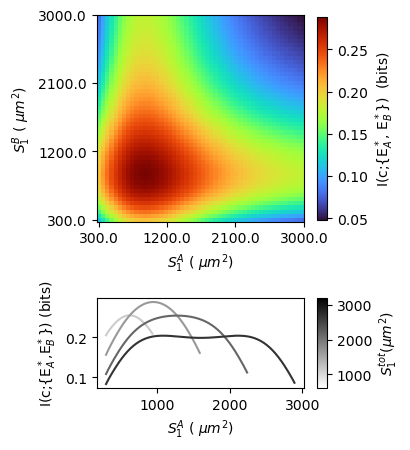

In [36]:
# Figure 
color = cm.gray_r(np.linspace(0, 0.8, len(S1A_S1t)))
norm = matplotlib.colors.Normalize(vmin=np.min(S1tot_temp), vmax=np.max(S1tot_temp)) 
sm = matplotlib.cm.ScalarMappable(cmap='gray_r', norm=norm) 

x_tlabels= np.linspace(np.min(S1A_tt),np.max(S1A_tt),4) # S1A temp
y_tlabels= np.linspace(np.min(S1B_tt),np.max(S1B_tt),4) # S1B temp
xLab = [str(np.round(x_tlabels[i],0)) for i in range(len(x_tlabels))]
yLab = [str(np.round(y_tlabels[i],0)) for i in range(len(x_tlabels))]

norm1 = matplotlib.colors.Normalize(vmin=np.min(I_S1AS1B_mat), vmax=np.max(I_S1AS1B_mat)) 
sm1 = matplotlib.cm.ScalarMappable(cmap='turbo', norm=norm1)   

f, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [2, 0.8]}, figsize=(4,4.7))

ax0.imshow(I_S1AS1B_mat, cmap='turbo', origin='lower')
plt.colorbar(sm1, label='I(c;{E$_A^*$, E$_B^*$})  (bits)', shrink=0.9, ax=ax0)
ax0.set_xlabel('$S_{1}^A$ ( $\\mu m^2$)')
ax0.set_ylabel('$S_{1}^B$ ( $\\mu m^2$)')
ax0.set_xticks(np.linspace(0,n-0.5,4), labels = xLab )
ax0.set_yticks(np.linspace(0,n-0.5,4), labels = yLab )

for i in range(1, len(S1A_S1t)):
    ax1.plot(S1A_S1t[i], Info_S1AS1B_S1t[i],'-', label= np.round(S1tot_temp[i]), color=color[i])

cb = plt.colorbar(sm, aspect=9, orientation='vertical', ax=ax1, label='$S_1^{tot}  (\\mu m^2)$')
ax1.set_xlabel('$S_{1}^A$ ( $\\mu m^2$)', fontsize=10)
ax1.set_ylabel('I(c;{E$^*_A$,E$^*_B$}) (bits)', fontsize=10)

plt.tight_layout()
plt.show()

## Fig. 3(c), 3(d), S3(a), S3(b)

The following code reproduces Fig. 3(c) and 3(d).

To reproduce Fig. S3(a) impose: e_v= $10^{-9}$. 

To reproduce Fig. S3(b) impose: e_v = 5, and mu_c = 5, 10, 20, 30. 

In [39]:
e_v = 5 

arA = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_prova, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, ScellA_v]
arB = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1_prova, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
       Rt_v, Erkt_v, ScellB_v]


Compute the information along the straight lines defined by $S_1^A + S_1^B = S_1^{tot}$

In [41]:
# Compute the input distribution
mu_c = 40 
sigma_F= 1

cmin = np.max((mu_c -5*sigma_F, 0.1))
cmax = mu_c +5*sigma_F
c_temp = np.linspace(cmin, cmax, 50)
P_in =  Pf_Lognorm(c_temp, sigma_F=sigma_F, mu_c=mu_c)

In [42]:
# Max and min S1tot 
S1totmax = (SmaxA + SmaxB)
S1totmin = SminA + SminB
S1tot_temp = np.round(np.linspace(S1totmin, S1totmax, 50), 2) 

# To exactly reproduce Fig. 3(c) and (d): 
# S1tot_temp = np.round(np.linspace(S1totmin, S1totmax, 60), 2)

In [43]:
# Define the vectors to store the results  
S1A_S1t = []  
S1B_S1t = []
Info_S1AS1B_S1t = []

for k in range(len(S1tot_temp)):
    
    # Create the vectors S1A, S1B such that S1A + S1B = S1tot
    S1A_temp = np.round(np.linspace(SminA, SmaxA, 100),2) 
    # To exactly reproduce Fig. 3(c) and (d): 
    # S1A_temp = np.round(np.linspace(SminA, SmaxA, 200),2) 
    S1B_temp = np.round(S1tot_temp[k]- S1A_temp, 2)
        
    S1B_temp[np.where(S1B_temp < SminB)] = 'NaN'
    S1B_temp[np.where(S1B_temp > SmaxB)] = 'NaN'
     
    S1A_temp = np.ravel(S1A_temp[~np.isnan(S1B_temp)])
    S1B_temp = np.ravel(S1B_temp[~np.isnan(S1B_temp)])
    
    S1A_S1t.append(S1A_temp)
    S1B_S1t.append(S1B_temp)
       
    # Create list of arguments needed to compute S[P({EA, EB})]
    arg_Spout = [] 
    
    for i in range(len(S1A_temp)): 

        # Update the parameter values with the correct S1A and S1B
        argsA = arA[0:4]+[S1A_temp[i]]+arA[5:]
        argsB = arB[0:4]+[S1B_temp[i]]+arB[5:] 
        
        ERKvAmin = ERK(cmin, args=argsA)
        ERKvBmin = ERK(cmin, args=argsB)
        
        ERKvAmax = ERK(cmax, args=argsA)
        ERKvBmax = ERK(cmax, args=argsB)
    
        ERKvAmin = np.max((1e-4, ERKvAmin- ERKvAmin/4))
        ERKvBmin = np.max((1e-4, ERKvBmin- ERKvBmin/4))
        
        ERKA = np.linspace(ERKvAmin, ERKvAmax+ERKvAmax/4, 100)
        ERKB = np.linspace(ERKvBmin, ERKvBmax+ERKvBmax/4, 100)
        
        arg_Spout.append((ERKA, ERKB, c_temp, P_in, argsA, argsB))
         
    # Compute the entropy of the output distribution 
    if __name__ == '__main__': 
        p = mp.Pool(ncores)
        SPout_2cells_S1t = p.map(SPERK_mp, arg_Spout)

    # Compute information as a function of S1A and S1B
    arg_I = []

    for i in range(len(S1A_temp)):
        argsA = arA[0:4]+[S1A_temp[i]]+arA[5:]
        argsB = arB[0:4]+[S1B_temp[i]]+arB[5:]
        
        arg_I.append((c_temp, P_in, SPout_2cells_S1t[i], argsA, argsB))
        
    if __name__ == '__main__': 
        p = mp.Pool(ncores)
        Info_S1AS1B = p.map(I_2cells_mp, arg_I)
        
    Info_S1AS1B_S1t.append(Info_S1AS1B)

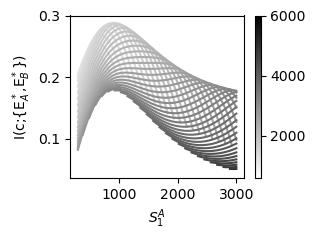

In [44]:
# Plot the curves I([FGF]; {EA*, EB*}) for the different values of S1tot

color = cm.gray_r(np.linspace(0, 0.8, len(S1A_S1t)))
norm = matplotlib.colors.Normalize(vmin=np.min(S1tot_temp), vmax=np.max(S1tot_temp))
sm = matplotlib.cm.ScalarMappable(cmap='gray_r', norm=norm)    


plt.figure(figsize=(3.3,2.5))
for i in range(1, len(S1A_S1t)):
    plt.plot(S1A_S1t[i], Info_S1AS1B_S1t[i],'-', label= np.round(S1tot_temp[i]), color=color[i])

ax = plt.gca()
cb = plt.colorbar(sm, aspect=30, orientation='vertical', ax=ax)
plt.xlabel('$S_{1}^A$', fontsize=10)
plt.ylabel('I(c;{E$^*_A$,E$^*_B$})', fontsize=10)
plt.tight_layout()
plt.show()


For each curve, compute the maximal transmitted information $I^*$ and the surface that maximise information transmission $S_1^*$

In [46]:
# Compute the position of the peaks:
S1A_peaks = []
S1B_peaks = []
maxI_S1tA = []

for i in range(len(S1tot_temp)):

    info = np.round(Info_S1AS1B_S1t[i], 6)
    info[np.isnan(info)] = 0.0
    max_Info = np.max(info)

    I_peaks = info[info==max_Info]

    maxI_S1tA.append(I_peaks)
    S1A_peaks.append(np.round(S1A_S1t[i][info==max_Info].tolist(),1))
    S1B_peaks.append(np.round(S1B_S1t[i][info==max_Info].tolist(),1))

# Rearrange the vectors for the plot 
S1t_plot = []
S1A_peaks_plot = []
S1B_peaks_plot = []
I_peak_plot = []

for i in range(len(S1tot_temp)): 
    for j in range(len(S1A_peaks[i])):
        S1A_peaks_plot.append(S1A_peaks[i][j])
        S1B_peaks_plot.append(S1B_peaks[i][j])
        I_peak_plot.append(maxI_S1tA[i][j])
        S1t_plot.append(S1tot_temp[i])
    

Compute the information $I_{avg}$ transmitted if the 2 cells have the same surface exposed to FGF: $S_1^A=S_1^B=S_1^{tot}/2$

In [48]:
# Compute the information transmitted if the 2 cells have the same surface exposed to FGF: S1A=S1B=S1tot/2
avgI_S1t = []

for k in range(len(S1tot_temp)): 
    
    # Check that S1tot_temp/2 is lower than the maxS1 for the 2 cells: 
    if S1tot_temp[k]/2 > np.min((ScellA_v/2, ScellB_v/2)): 
        avgI_S1t.append(np.NaN)
    else:
        arA = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1tot_temp[k]/2, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
               Rt_v, Erkt_v, ScellA_v]
        arB = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1tot_temp[k]/2, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
               Rt_v, Erkt_v, ScellB_v]

        ERKminA = ERK(cmin, args=arA)
        ERKminB = ERK(cmin, args=arB)

        ERKmaxA = ERK(cmax, args=arA)
        ERKmaxB = ERK(cmax, args=arB)

        ERKminA = np.max((1e-4, ERKminA- ERKminA/4))
        ERKminB = np.max((1e-4, ERKminB- ERKminB/4))

        ERKmaxA = ERKmaxA+ERKmaxA/4
        ERKmaxB = ERKmaxB+ERKmaxB/4

        ERK_tempA = np.linspace(ERKminA, ERKmaxA, 100)
        ERK_tempB = np.linspace(ERKminB, ERKmaxB, 100)

        # Compute the integral of the output distribution 
        avgSPerk_prova_2c = SPERK_2c(ERK_tempA, ERK_tempB, c_temp, P_in, argsA=arA, argsB=arB)

        avgI_S1t_temp = I_2cells(c_temp, Pin=P_in, SPout=avgSPerk_prova_2c, argsA=arA, argsB=arB)

        avgI_S1t.append(avgI_S1t_temp)

Compute the difference $I^* -I_{avg}$

In [50]:
S1t_unique, indices = np.unique(S1t_plot, return_index=True)

I_unique = np.array(I_peak_plot)[indices]
diff_I = I_unique - np.array(avgI_S1t)

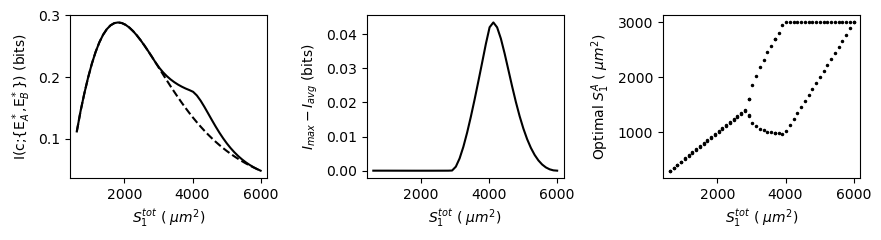

In [51]:
# Figure

f, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=(9,2.5))

# Plot max I(c, {EA, EB}) as a function of S1tot
ax0.plot(S1t_plot, I_peak_plot,'-', color='k', label='Maximal I with ephrin', linewidth=1.5)
ax0.plot(S1tot_temp, avgI_S1t,'--', color='k', label='I if the 2 cells \nhave the same $S_1$', linewidth=1.5)

ax0.set_xlabel('$S_{1}^{tot}$ ( $\\mu m^2$)', fontsize=10)
ax0.set_ylabel('I(c;{E$^*_A$,E$^*_B$}) (bits)', fontsize=10)
ax0.set_xlim([S1tot_temp[0]-200, S1tot_temp[-1]+200])

# Plot the difference between I* and I_avg 
ax1.plot(S1tot_temp, diff_I,'-', color='k', label='Maximal I with ephrin')
ax1.set_ylabel('$I_{max}-I_{avg}$ (bits)', fontsize=10)
ax1.set_xlabel('$S_{1}^{tot}$ ( $\\mu m^2$)', fontsize=10)
ax1.set_xlim([S1tot_temp[0]-200, S1tot_temp[-1]+200])

# Plot the position of the peaks as a function of S1tot
ax2.plot(S1t_plot, np.array(S1A_peaks_plot), '.',color='k',markersize=3, label=f'cell A (Scell = {ScellA_v})')
ax2.plot(S1t_plot, np.array(S1B_peaks_plot), '.',color='k',markersize=3, label=f'cell B (Scell = {ScellB_v})')

ax2.set_xlabel('$S_1^{tot}$ ( $\\mu m^2$)', fontsize=10)
ax2.set_ylabel('Optimal $S_{1}^A$ ( $\\mu m^2$)', fontsize=10)
ax2.set_xlim([S1tot_temp[0]-200, S1tot_temp[-1]+200])

plt.tight_layout()
plt.show()
